In [1]:
import csv
import pickle
from time import time


import pymc3 as pm
import pandas as pd
from pandas import DataFrame
import theano
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

from bayesumis.umis_math_model import UmisMathModel
from bayesumis.umis_diagram import UmisDiagram
from testhelper.test_helper import end_timer, DbStub
from testhelper import umis_builders
from testhelper.posterior_plotters import display_parameters, print_umis_diagram

theano.config.mode = 'FAST_RUN'
theano.config.optimizer = 'fast_compile'

test_db = DbStub()

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def time_run(math_model):
    sample_size = 3000
    start_time = time()

    with math_model.pm_model:
        trace = pm.sample(sample_size, init='adapt_diag')
    end_time = time()
    return (end_time-start_time, trace)

    

In [3]:
def build_math_model(umis_diagram, ref_material, ref_time):
    res_inflows = umis_diagram.get_external_inflows()
    res_outflows = umis_diagram.get_external_outflows()
    res_dict = umis_diagram.get_process_stafs_dict()
    
    math_model = UmisMathModel(
        res_inflows,
        res_dict,
        res_outflows,
        ref_material,
        ref_time,
        {},
        {})
    
    return math_model

In [24]:
def build_subsystems_math_models(n):

    ref_material = test_db.get_material_by_num(1)
    ref_time = test_db.get_time_by_num(1)
    
    math_models = []
    for i in range(0,n):
        
        (external_inflows,
         internal_flows,
         external_outflows,
         stocks,
         material_reconc_table,
         tc_obs) = umis_builders.get_umis_diagram_subsystems_test(23)
        
        internal_stafs = set.union(internal_flows, stocks)
        
        umis_diagram = UmisDiagram(
            external_inflows,
            internal_stafs,
            external_outflows)
        
        math_model = build_math_model(umis_diagram, ref_material, ref_time)
        
        math_models.append(math_model)
        
    return math_models

In [25]:
def run_subsystems_test(n):

    subsystem_math_models = build_subsystems_math_models(n)

    for j in range(0,1):
        filename = "subsystems_test_1_{}.csv".format(j)
#         with open(filename, 'w') as csvfile:
#             csvwriter = csv.writer(csvfile, delimiter=',',
#                                 quotechar='|', quoting=csv.QUOTE_MINIMAL)
#             csvwriter.writerow(['time', 'n_subsystems', 'mean_accept_probability'])


        for i, math_model in enumerate(subsystem_math_models):
            try:
#                 num_processes = i*2+1
                num_processes = 23
                time_taken, trace = time_run(math_model)
                
                accept = trace.get_sampler_stats('mean_tree_accept')
                accept_mean = accept.mean()
                print("Time taken: {}".format(time_taken))
                print("Num Processes: {}".format(num_processes))
                print("Mean Acceptance Probability: {}".format(accept_mean))
                with open(filename, 'a') as csvfile:
                    csvwriter = csv.writer(csvfile, delimiter=',',
                                        quotechar='|', quoting=csv.QUOTE_MINIMAL)
                    csvwriter.writerow([time_taken, num_processes, accept_mean])
                    
                with open('performance_traces/trace-{}-{}.pickle'.format(j, i), 'wb') as f:
                    pickle.dump(trace, f)

            except Exception as e:
                print("-------------------")
                print("Time taken: {}".format(time_taken))
                print("Num Processes: {}".format(num_processes))
                print("Mean Acceptance Probability: {}".format(accept_mean))
                print("-------------------")
                print("Failed because of {}".format(e))

run_subsystems_test(1)
    

Model built Tue 22:18


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/tom/anaconda3/envs/bayesian-umis/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Inflow-P17_Sp2_P18_Sp1, Inflow-P81_Sp2_P82_Sp1, Inflow-P1_Sp2

Time taken: 2100.0986137390137
Num Processes: 23
Mean Acceptance Probability: 0.831680436387726


In [7]:
# with open('performance_traces/test_trace.pickle', 'rb') as f:
#     read_pickle = pickle.load(f)
    
# print("Read pickle: {}".format(read_pickle))

In [8]:
# help(DataFrame.from_csv)

In [13]:
def read_performance_results_into_dataframe(n):
    num_subsystems = [p*2+1 for p in range(0,n)]
    num_processes = [3 * (p*2 + 1) for p in range(0,n)]
#     num_flows = [4 * (p*2 + 1) for p in range(0,n)]
#     num_tcs = [2 * (p*2 + 1) for p in range(0,n)]
#     full_df = DataFrame(
#         {
#             'num_subsystems': num_subsystems,
#             'num_processes': num_processes,
#             'num_flows': num_flows,
#             'num_tcs': num_tcs
#         })
#     full_df = full_df.set_index('num_subsystems')
#     for i in range(0,3):
#         file_name = 'subsystems_test_1{}.csv'.format(i)
#         t_df = pd.read_csv(file_name, header=0, index_col=1, names=['time_{}'.format(i), 'num_subsystems'])
#         full_df = pd.merge(full_df, t_df, on='num_subsystems')

    
#     df_average = full_df.copy()
# #     print(df_average[['time_0', 'time_1', 'time_2']])
#     df_average['average'] = df_average[['time_0', 'time_1', 'time_2']].mean(axis=1)

    df_average = pd.read_csv('subsystems_test_1_0.csv')
    df_num_processes = DataFrame({'num_processes': num_processes, 'n_subsystems': num_subsystems})
    df_average = pd.merge(df_average, df_num_processes)
    return df_average
    
df_average = read_performance_results_into_dataframe(11)
print(df_average)       

           time  n_subsystems  mean_accept_probability  num_processes
0     35.932245             1                 0.866873              3
1    105.704473             3                 0.850108              9
2    169.778657             5                 0.843185             15
3    266.270517             7                 0.835301             21
4    558.554099             9                 0.838775             27
5   1024.610578            11                 0.820907             33
6    510.584566            13                 0.815516             39
7    864.309991            15                 0.824238             45
8   1537.192194            17                 0.826092             51
9   1899.350182            19                 0.818771             57
10  2299.919543            21                 0.812625             63


In [29]:
# print(df_average)
num_subsystems = [p*2+1 for p in range(0,11)]
num_stafs = [4 * (p*2 + 1) for p in range(0,11)]
df_num_stafs = DataFrame({'num_stafs': num_stafs, 'n_subsystems': num_subsystems})

df_average = pd.merge(df_average, df_num_stafs)
print(df_average)

           time  n_subsystems  mean_accept_probability  num_processes  \
0     35.932245             1                 0.866873              3   
1    105.704473             3                 0.850108              9   
2    169.778657             5                 0.843185             15   
3    266.270517             7                 0.835301             21   
4    558.554099             9                 0.838775             27   
5   1024.610578            11                 0.820907             33   
6    510.584566            13                 0.815516             39   
7    864.309991            15                 0.824238             45   
8   1537.192194            17                 0.826092             51   
9   1899.350182            19                 0.818771             57   
10  2299.919543            21                 0.812625             63   

    num_stafs  
0           4  
1          12  
2          20  
3          28  
4          36  
5          44  
6          

<Figure size 432x288 with 0 Axes>

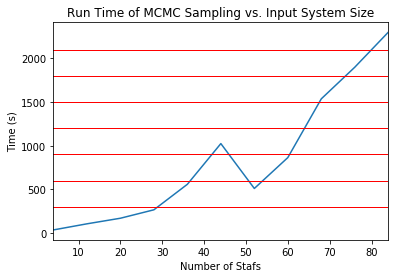

<Figure size 432x288 with 0 Axes>

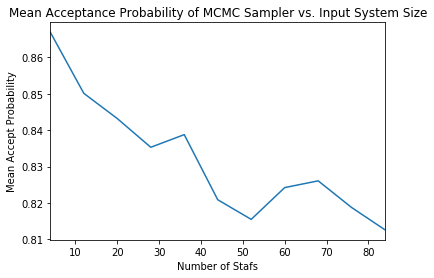

In [30]:
def plot_times(df):
#     df = df.loc['num_subsystems']
#     print(df.keys())
    fig = plt.figure()
    ax = df.plot(x='num_stafs', y='time', legend=None)
    for i in range(1,8):
        y = i*300
        ax.axhline(y, color='r', linewidth=1)
    ax.set_ylabel('Time (s)')
    ax.set_xlabel('Number of Stafs')
    ax.set_title("Run Time of MCMC Sampling vs. Input System Size")
#     fig = plt.figure()
#     ax = df.plot(x='num_flows', y='average')
#     ax.set_ylabel('Time (s)')
#     ax.set_xlabel('Number of Flows')
    
    fig = plt.figure()
    ax = df.plot(x='num_stafs', y='mean_accept_probability', legend=None)
    ax.set_ylabel('Mean Accept Probability')
    ax.set_xlabel('Number of Stafs')
    ax.set_title("Mean Acceptance Probability of MCMC Sampler vs. Input System Size")
    
    
#     plt.show()
    
plot_times(df_average)